## Calculating the metrics

In [1]:
# Paste your paths to folders with classifier logits here.
logits_path = {
    "sd_14": "YOUR_PATH_TO_NPZ",
    "ldm": "YOUR_PATH_TO_NPZ",
    "unclip": "YOUR_PATH_TO_NPZ",
    "glide": "YOUR_PATH_TO_NPZ",
    "sd_20": "YOUR_PATH_TO_NPZ",
}

In [2]:
import importlib
from src import hierarchy
from src import metrics

hierarchy = importlib.reload(hierarchy)
metrics = importlib.reload(metrics)

In [ ]:
from pathlib import Path

dataset_classes_path = Path("../wordnet_classes/imagenet.txt")
dataset_hierarchy = hierarchy.Hierarchy(dataset_classes_path.resolve())

in_prob_metric = metrics.SubtreeInProb(dataset_hierarchy, 32)
is_metric = metrics.SubtreeIS(dataset_hierarchy, 32)

In [4]:
synset_num_children = {}

for synset in dataset_hierarchy.get_all_synsets(remove_leaves=True):
    n_ch = len(dataset_hierarchy.get_classifiable_subtree(synset))
    synset_num_children[synset.name()] = n_ch

more_than_one_child_fn = lambda x: synset_num_children[x] > 1

In [5]:
import numpy as np


sorted_keys = np.array([k for k, v in sorted(synset_num_children.items(), key=lambda x: x[0])])
n_ch_array = np.array([v for k, v in sorted(synset_num_children.items(), key=lambda x: x[0])])
print((n_ch_array == 1).sum(), (n_ch_array != 1).sum())

388 472


In [6]:
max_is_unnormed = np.log(n_ch_array[n_ch_array != 1]).mean()

In [7]:
model_results = {
    k: (in_prob_metric.compute_metric(v), is_metric.compute_metric(v))
    for k, v in logits_path.items()
}

In [8]:
print("Model", "ISP", "SCS", sep="\t")

for k, v in model_results.items():
    avg_isp = v[0]["average"]
    avg_scs = v[1]["average"] / max_is_unnormed
    print(k, f"{avg_isp:.2f}", f"{avg_scs:.2f}", sep="\t")

Model	ISP	SCS
sd_14	0.33	0.26
ldm	0.22	0.18
unclip	0.35	0.19
glide	0.22	0.20
sd_20	0.30	0.23


## Finding unknown concepts

(Figure 4)

In [14]:
import matplotlib.pyplot as plt

In [9]:
model_paths = {
    "sd_14": "sd14_75",
    "sd_20": "sd20_75",
    "ldm": "ldm_75",
    "glide": "glide_75",
    "unclip": "unclip_75",
}

pretty_names = {
    "sd_14": "SD v1.4",
    "sd_20": "SD v2.0",
    "ldm": "LDM",
    "glide": "GLIDE",
    "unclip": "unCLIP",
}

In [10]:
# Change this to "SCS" if you want to compare by SCS.
metric_type = "ISP"

In [11]:
synset_metric = {
    model_name: {k: v for k, v in metrics[0 if metric_type == "ISP" else 1].items() if k != "average"}
    for model_name, metrics in model_results.items()
}

In [12]:
import matplotlib.image as mpimg

def draw_synsets(keys):
    model_keys = ["glide", "ldm", "sd_14", "sd_20", "unclip"]
    plt.grid("off")
    
    model_avg = {}
    for model in model_keys:
        model_avg[model] = 0
        for s in keys:
            model_avg[model] += synset_metric[model][s]
        model_avg[model] /= len(keys)
    
    for i, s in enumerate(keys):
        for j, model in enumerate(model_keys):
            plt.subplot(len(keys), len(synset_metric), i * len(synset_metric) + j + 1)

            if i == 0:
                plt.gca().xaxis.tick_top()
                plt.gca().xaxis.set_label_position('top')
                
                plt.xlabel(f"({model_avg[model]:.4f})")
                plt.title(pretty_names[model], fontsize=10)

            img = mpimg.imread(f"{model_paths[model]}/{s}/0.png")
            plt.imshow(img)
            plt.xticks([], [])
            plt.yticks([], [])
            
            if j == 0:
                sv = s.split(".")[0]
                sv = "\n".join(sv.split("_"))
                plt.ylabel(sv, rotation=0, labelpad=25, va="center")

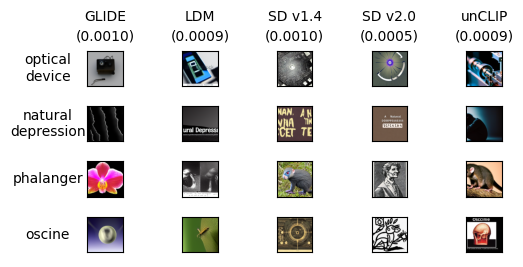

In [15]:
plt.figure(figsize=(5.5, 2.5))
draw_synsets(["optical_device.n.01", "natural_depression.n.01", "phalanger.n.01", "oscine.n.01"])
plt.tight_layout(pad=0.1, h_pad=1.08, w_pad=1.08)
plt.show()

## Granular comparison of models

(Figure 5)

In [16]:
synset_diff = [
    (synset_metric["sd_14"][k] - synset_metric["sd_20"][k], k)
    for k in sorted_keys
]
synset_diff.sort(reverse=True)

In [17]:
metric_values = np.array([x[0] for x in synset_diff])
metric_names = np.array([x[1].split('.')[0] for x in synset_diff])

In [18]:
high_values = metric_values[metric_values >= 0][::30]
low_values = metric_values[metric_values < 0][::-1][::30][::-1]

high_names = metric_names[metric_values >= 0][::30]
low_names = metric_names[metric_values < 0][::-1][::30][::-1]

In [19]:
import matplotlib

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})
%config InlineBackend.figure_format = 'retina'
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 14,
        "font.size": 14,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}
matplotlib.rcParams.update(nice_fonts)

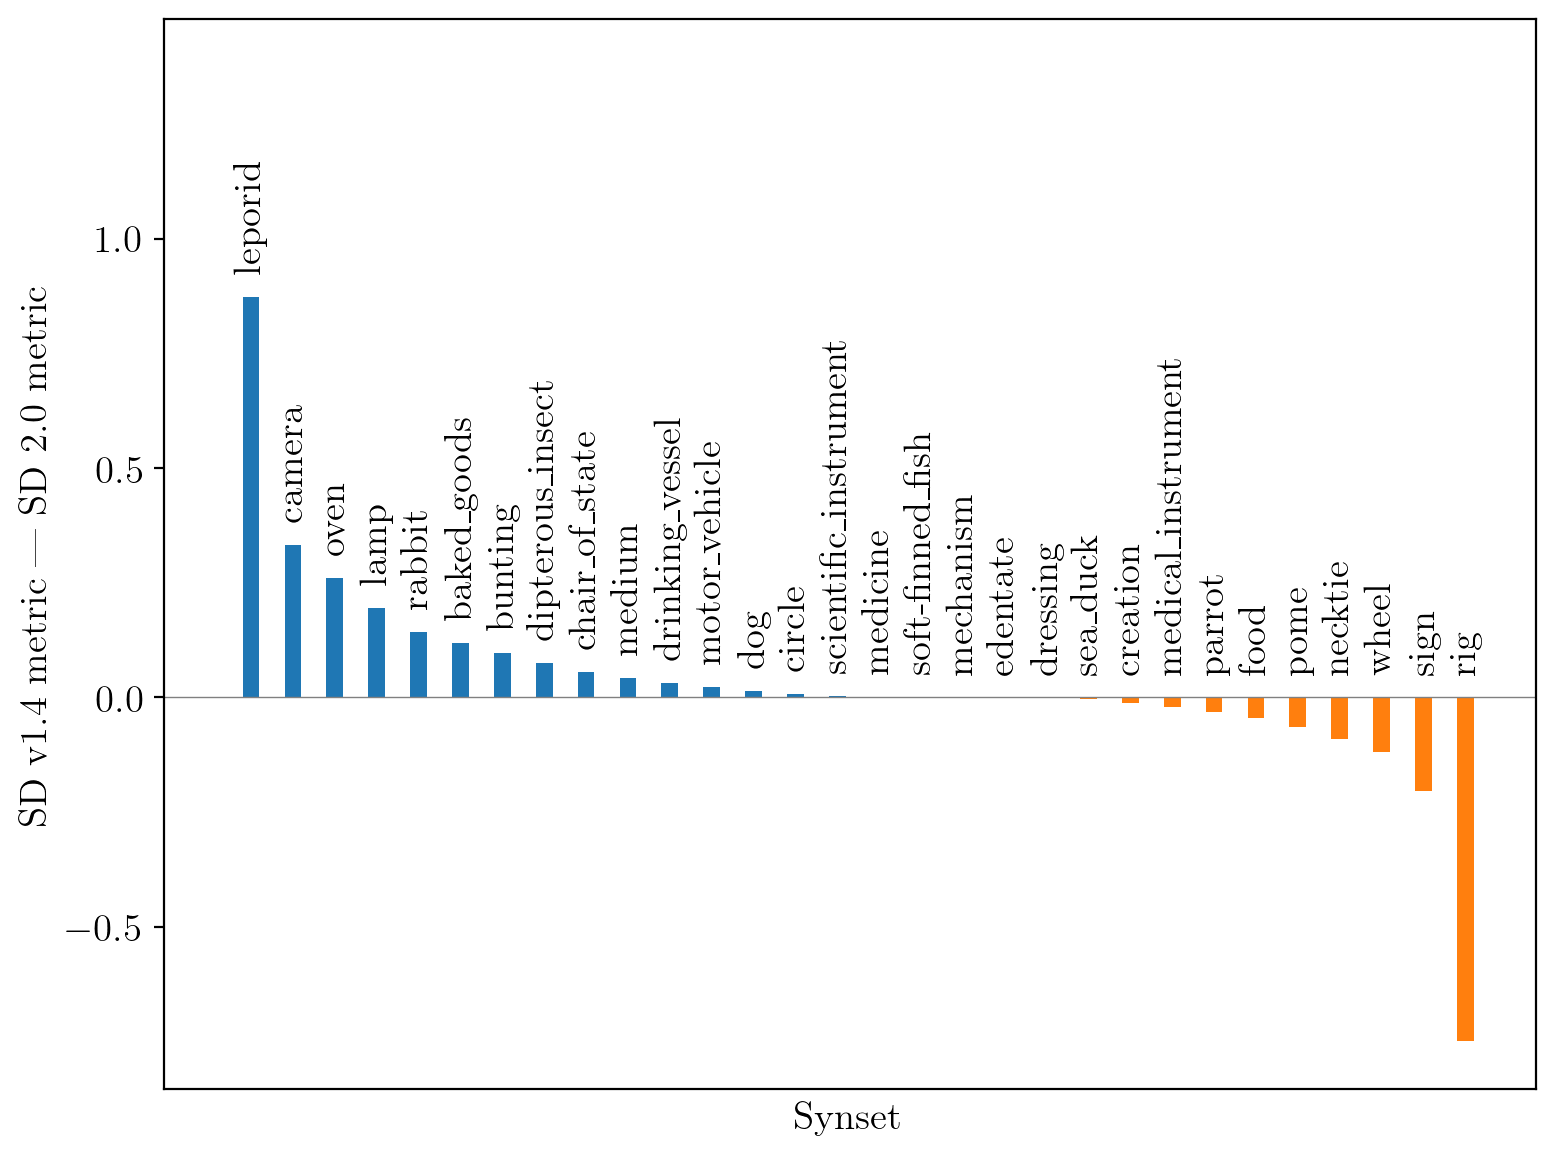

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.xlabel('Synset')
plt.ylabel('SD v1.4 metric — SD 2.0 metric')

bar_width = 0.4

bar_high = plt.bar(
    np.arange(len(high_values)) + bar_width, high_values, bar_width, align='center')
bar_low = plt.bar(
    np.arange(len(low_values)) + bar_width + len(high_values), low_values, bar_width, align='center')

bar_none = plt.bar(
    np.arange(2), [max(high_values) + 0.5, min(low_values)],
    bar_width, align='center', label='Fast <= 6 sec.', alpha=0.0)

# Add counts above the two bar graphs
for i, rect in enumerate(bar_high):
    height = rect.get_height()

    plt.text(
        rect.get_x() + rect.get_width() / 2,
        height + 0.05,
        f"{high_names[i]}",
        ha='center', va='bottom', rotation=90)

for i, rect in enumerate(bar_low):
    height = rect.get_height()
    x_offset = rect.get_width() * ((6 - len(low_names[i])) / 6)
    y_offset = 0.05 * ((6 - len(low_names[i])) / 6)

    plt.text(
        rect.get_x() + rect.get_width() / 2,
        0.05,
        f"{low_names[i]}",
        ha='center', va='bottom', rotation=90, horizontalalignment="left")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.gca().axhline(0, linestyle='-', color='gray', lw=0.5) # horizontal lines
plt.show()